# Setup for Google Colab

**Instructions:**
1. Run the cells below to clone the dataset from GitHub
2. The dataset will be downloaded to `/content/Fetal-Head-Segmentation/shared/dataset_v5/`
3. All subsequent cells will work with this path automatically

In [ ]:
# Clone the repository (only run once)
import os
from pathlib import Path

# Check if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

if IN_COLAB:
    # Clone repository if not already present
    if not os.path.exists('/content/Fetal-Head-Segmentation'):
        print("Cloning repository...")
        !git clone https://github.com/TrinhThaiSonDHQT/Fetal-Head-Segmentation.git
        print("Repository cloned successfully!")
    else:
        print("Repository already exists.")
    
    # Set base path for Colab
    BASE_PATH = Path('/content/Fetal-Head-Segmentation')
else:
    # Set base path for local environment
    BASE_PATH = Path(r'e:\Fetal Head Segmentation')

print(f"Base path: {BASE_PATH}")
print(f"Base path exists: {BASE_PATH.exists()}")

# Exploratory Data Analysis (EDA) - Fetal Head Segmentation Dataset

**Dataset:** Large-Scale Fetal Head Biometry from Zenodo (dataset_v4)

**Objective:** Analyze the dataset characteristics including:
- Image size distribution
- Pixel intensity histograms
- Dataset split statistics
- Anatomical plane distribution
- Mask coverage analysis

## 1. Import Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Dataset path (automatically set based on environment)
DATASET_PATH = BASE_PATH / 'shared' / 'dataset_v5'
METADATA_PATH = DATASET_PATH / 'dataset_metadata.csv'

print(f"Dataset path: {DATASET_PATH}")
print(f"Dataset exists: {DATASET_PATH.exists()}")

Dataset path: e:\Fetal Head Segmentation\shared\dataset_v5
Dataset exists: True


## 2. Load and Explore Metadata

In [7]:
# Load metadata
df = pd.read_csv(METADATA_PATH)

print("Dataset Overview:")
print(f"Total images: {len(df)}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nDataset info:")
print(df.info())
print(f"\nBasic statistics:")
print(df.describe())

Dataset Overview:
Total images: 3792

First few rows:
                         filename         split        plane    patient_id  \
0  Patient01095_Plane3_1_of_4.png  training_set     thalamic  Patient01095   
1  Patient01095_Plane3_2_of_4.png  training_set     thalamic  Patient01095   
2  Patient01095_Plane3_3_of_4.png  training_set     thalamic  Patient01095   
3  Patient01095_Plane3_4_of_4.png  training_set     thalamic  Patient01095   
4  Patient01123_Plane3_2_of_4.png  training_set   cerebellum  Patient01123   
5  Patient01123_Plane3_1_of_4.png  training_set     thalamic  Patient01123   
6  Patient01123_Plane3_3_of_4.png  training_set     thalamic  Patient01123   
7  Patient01123_Plane3_4_of_4.png  training_set  ventricular  Patient01123   
8  Patient00666_Plane3_1_of_1.png  training_set     thalamic  Patient00666   
9  Patient00824_Plane3_1_of_3.png  training_set     thalamic  Patient00824   

  pixel_size_mm  
0   0.171526587  
1   0.144300144  
2   0.144300144  
3    0.13568521

## 3. Dataset Split Analysis

Dataset Split Distribution:
split
training_set      2642
validation_set     583
test_set           567
Name: count, dtype: int64

Percentages:
split
training_set      69.672996
validation_set    15.374473
test_set          14.952532
Name: proportion, dtype: float64


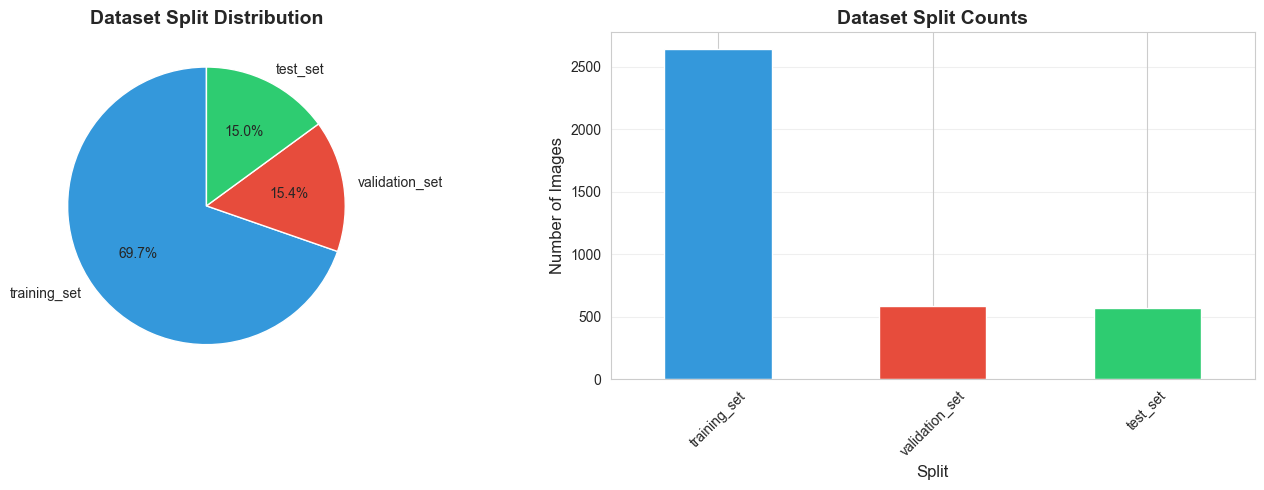


Patient-Level Split:
split
training_set      1288
test_set           276
validation_set     276
Name: count, dtype: int64

Unique patients per split:
training_set: 1288 patients
validation_set: 276 patients
test_set: 276 patients


In [8]:
# Analyze dataset splits
split_counts = df['split'].value_counts()
print("Dataset Split Distribution:")
print(split_counts)
print(f"\nPercentages:")
print(df['split'].value_counts(normalize=True) * 100)

# Visualize splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(split_counts.values, labels=split_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')

# Bar chart
split_counts.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Dataset Split Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Patient distribution across splits
print(f"\nPatient-Level Split:")
patient_splits = df.groupby('patient_id')['split'].first().value_counts()
print(patient_splits)
print(f"\nUnique patients per split:")
for split in df['split'].unique():
    unique_patients = df[df['split'] == split]['patient_id'].nunique()
    print(f"{split}: {unique_patients} patients")

In [9]:
# DIAGNOSTIC: Check for patient leakage across splits
print("\n" + "="*70)
print("CHECKING FOR DATA LEAKAGE")
print("="*70)

# Find patients that appear in multiple splits
patient_split_mapping = df.groupby('patient_id')['split'].apply(set)
patients_in_multiple_splits = patient_split_mapping[patient_split_mapping.apply(len) > 1]

print(f"\nPatients appearing in multiple splits: {len(patients_in_multiple_splits)}")
print(f"Total unique patients: {df['patient_id'].nunique()}")

if len(patients_in_multiple_splits) > 0:
    print(f"\n⚠️ WARNING: DATA LEAKAGE DETECTED!")
    print(f"   {len(patients_in_multiple_splits)} patients appear in multiple splits")
    print(f"\n   Examples of leaked patients:")
    for patient_id, splits in list(patients_in_multiple_splits.head(5).items()):
        image_counts = df[df['patient_id'] == patient_id]['split'].value_counts()
        print(f"   - {patient_id}: {list(splits)} -> {dict(image_counts)}")
else:
    print(f"\n✓ No data leakage: All patients are in exactly one split")

print("="*70)


CHECKING FOR DATA LEAKAGE

Patients appearing in multiple splits: 0
Total unique patients: 1840

✓ No data leakage: All patients are in exactly one split


## 4. Anatomical Plane Distribution

Anatomical Plane Distribution:
plane
thalamic       1557
diverse         999
cerebellum      681
ventricular     555
Name: count, dtype: int64

Percentages:
plane
thalamic       41.060127
diverse        26.344937
cerebellum     17.958861
ventricular    14.636076
Name: proportion, dtype: float64

Plane Distribution by Split:
split        test_set  training_set  validation_set   All
plane                                                    
cerebellum        107           469             105   681
diverse           171           688             140   999
thalamic          212          1091             254  1557
ventricular        77           394              84   555
All               567          2642             583  3792


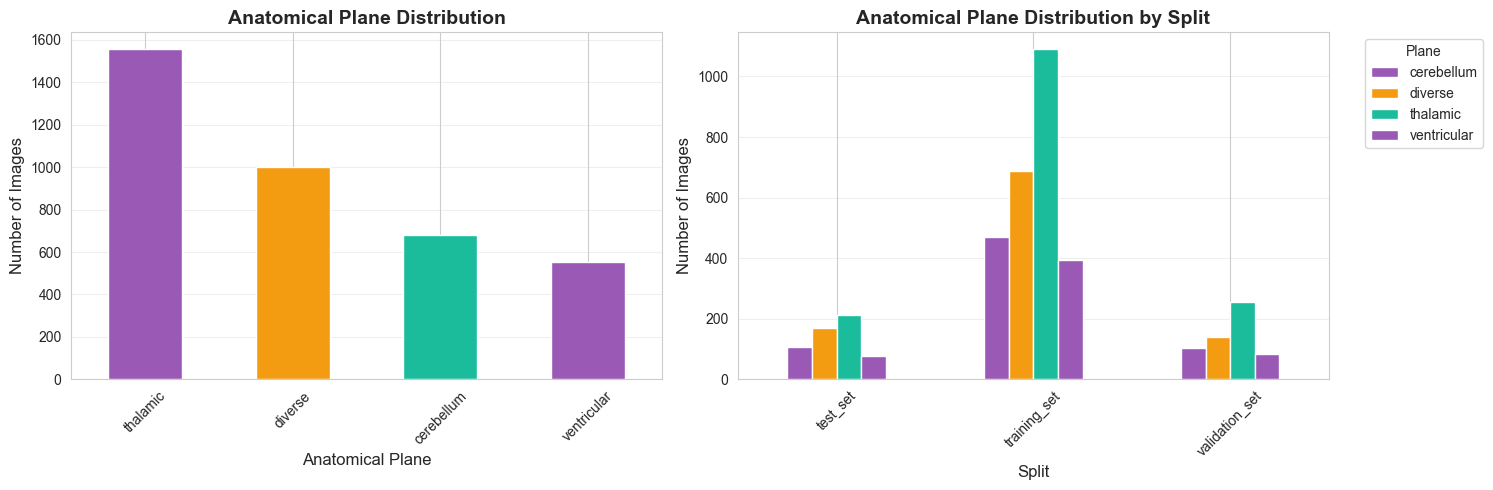

In [10]:
# Analyze anatomical planes
plane_counts = df['plane'].value_counts()
print("Anatomical Plane Distribution:")
print(plane_counts)
print(f"\nPercentages:")
print(df['plane'].value_counts(normalize=True) * 100)

# Plane distribution across splits
print(f"\nPlane Distribution by Split:")
plane_split = pd.crosstab(df['plane'], df['split'], margins=True)
print(plane_split)

# Visualize plane distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
plane_counts.plot(kind='bar', ax=axes[0], color=['#9b59b6', '#f39c12', '#1abc9c'])
axes[0].set_title('Anatomical Plane Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Anatomical Plane', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Grouped by split
df_grouped = df.groupby(['split', 'plane']).size().unstack(fill_value=0)
df_grouped.plot(kind='bar', ax=axes[1], color=['#9b59b6', '#f39c12', '#1abc9c'])
axes[1].set_title('Anatomical Plane Distribution by Split', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].legend(title='Plane', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Image Size Distribution Analysis

In [12]:
# Sample images to analyze (use subset for faster processing)
def get_image_dimensions(split_name, sample_size=200):
    """Get dimensions of images from a specific split"""
    split_df = df[df['split'] == split_name].sample(min(sample_size, len(df[df['split'] == split_name])), random_state=42)
    
    widths = []
    heights = []
    aspect_ratios = []
    
    for filename in tqdm(split_df['filename'], desc=f"Processing {split_name}"):
        img_path = DATASET_PATH / split_name / 'images' / filename
        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                h, w = img.shape
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
    
    return widths, heights, aspect_ratios

# Collect image dimensions from all splits
all_widths = []
all_heights = []
all_aspect_ratios = []

for split in df['split'].unique():
    widths, heights, aspect_ratios = get_image_dimensions(split)
    all_widths.extend(widths)
    all_heights.extend(heights)
    all_aspect_ratios.extend(aspect_ratios)

print(f"\nImage Dimension Statistics:")
print(f"Width  - Min: {min(all_widths)}, Max: {max(all_widths)}, Mean: {np.mean(all_widths):.2f}, Std: {np.std(all_widths):.2f}")
print(f"Height - Min: {min(all_heights)}, Max: {max(all_heights)}, Mean: {np.mean(all_heights):.2f}, Std: {np.std(all_heights):.2f}")
print(f"Aspect Ratio - Min: {min(all_aspect_ratios):.3f}, Max: {max(all_aspect_ratios):.3f}, Mean: {np.mean(all_aspect_ratios):.3f}")

# Count unique dimensions
unique_sizes = Counter(zip(all_widths, all_heights))
print(f"\nNumber of unique image sizes: {len(unique_sizes)}")
print(f"Most common image sizes:")
for size, count in unique_sizes.most_common(10):
    print(f"  {size[0]}x{size[1]}: {count} images")

Processing test_set: 100%|██████████| 200/200 [00:01<00:00, 101.51it/s]


Image Dimension Statistics:
Width  - Min: 959, Max: 959, Mean: 959.00, Std: 0.00
Height - Min: 661, Max: 661, Mean: 661.00, Std: 0.00
Aspect Ratio - Min: 1.451, Max: 1.451, Mean: 1.451

Number of unique image sizes: 1
Most common image sizes:
  959x661: 600 images


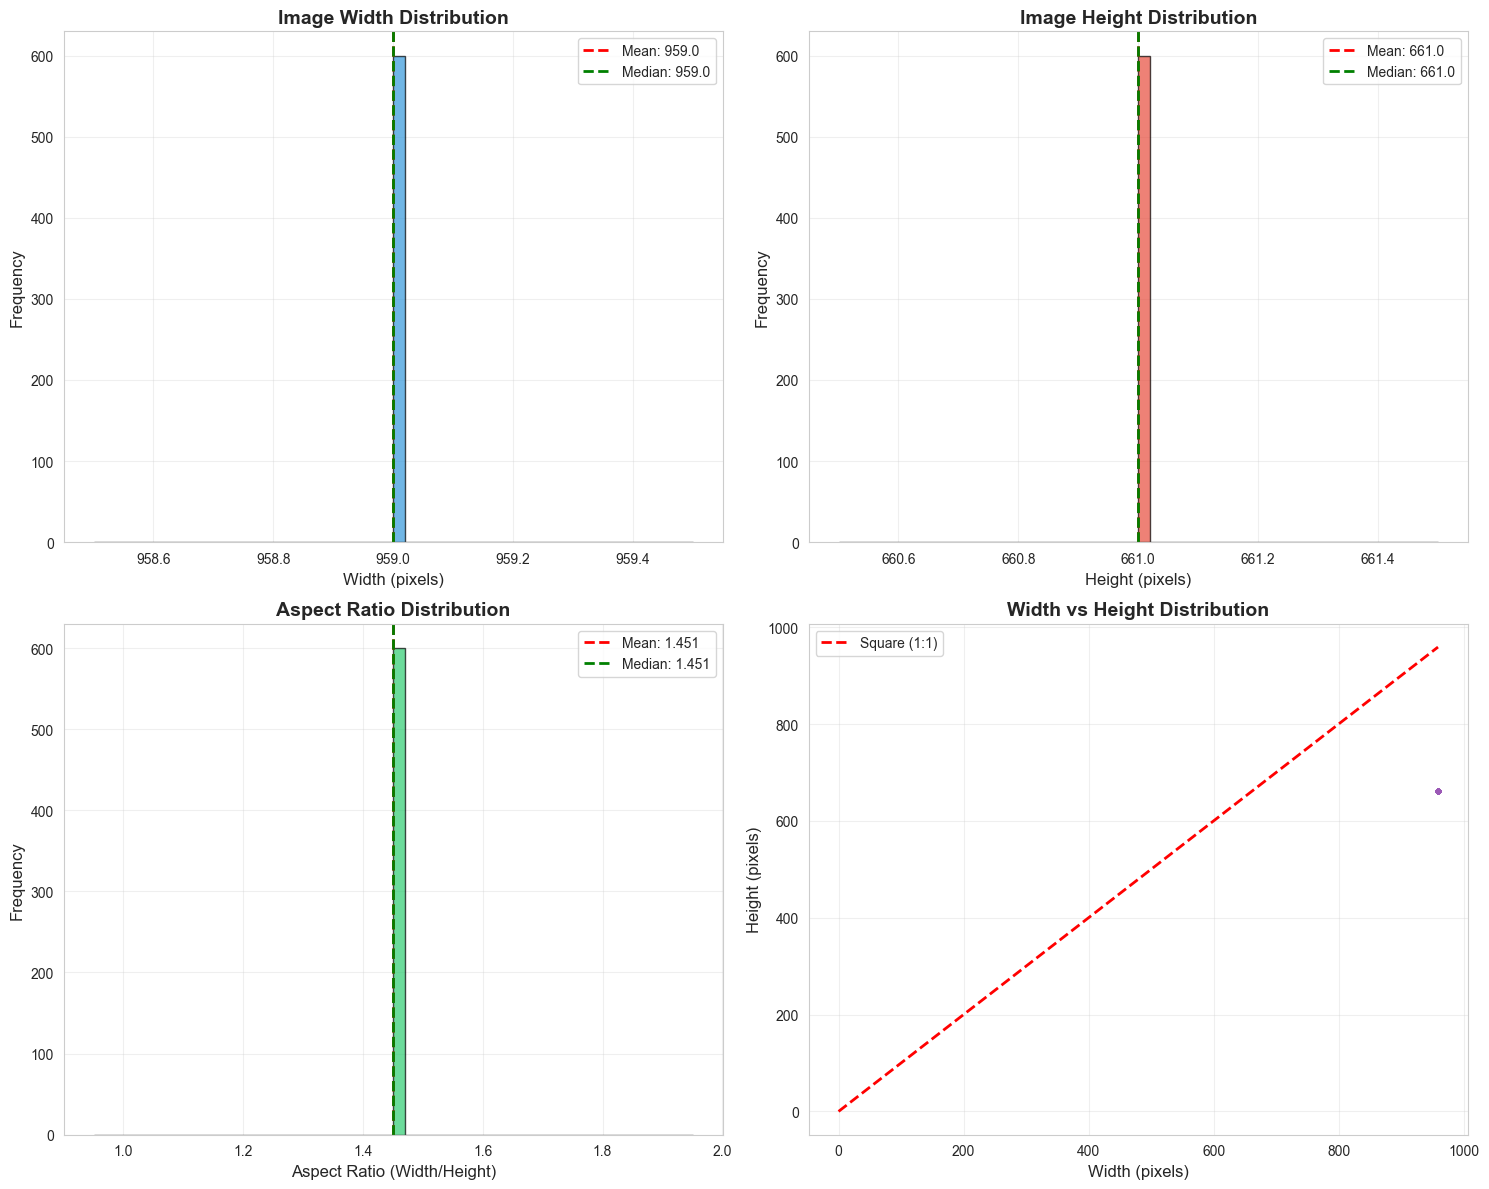

In [13]:
# Visualize image size distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Width distribution
axes[0, 0].hist(all_widths, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(all_widths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_widths):.1f}')
axes[0, 0].axvline(np.median(all_widths), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_widths):.1f}')
axes[0, 0].set_title('Image Width Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(all_heights, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(all_heights), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_heights):.1f}')
axes[0, 1].axvline(np.median(all_heights), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_heights):.1f}')
axes[0, 1].set_title('Image Height Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(all_aspect_ratios, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(np.mean(all_aspect_ratios), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_aspect_ratios):.3f}')
axes[1, 0].axvline(np.median(all_aspect_ratios), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_aspect_ratios):.3f}')
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (Width/Height)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Scatter plot: Width vs Height
axes[1, 1].scatter(all_widths, all_heights, alpha=0.5, s=10, color='#9b59b6')
axes[1, 1].plot([0, max(all_widths)], [0, max(all_widths)], 'r--', linewidth=2, label='Square (1:1)')
axes[1, 1].set_title('Width vs Height Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)', fontsize=12)
axes[1, 1].set_ylabel('Height (pixels)', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Pixel Intensity Distribution Analysis

In [14]:
# Analyze pixel intensity distribution from sample images
def analyze_pixel_intensities(split_name, sample_size=100):
    """Analyze pixel intensity statistics from a split"""
    split_df = df[df['split'] == split_name].sample(min(sample_size, len(df[df['split'] == split_name])), random_state=42)
    
    all_pixels = []
    mean_intensities = []
    std_intensities = []
    
    for filename in tqdm(split_df['filename'], desc=f"Analyzing {split_name}"):
        img_path = DATASET_PATH / split_name / 'images' / filename
        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                all_pixels.extend(img.flatten())
                mean_intensities.append(np.mean(img))
                std_intensities.append(np.std(img))
    
    return all_pixels, mean_intensities, std_intensities

# Collect pixel intensities from training set
all_pixels, mean_intensities, std_intensities = analyze_pixel_intensities('training_set', sample_size=150)

print(f"\nPixel Intensity Statistics (Training Set Sample):")
print(f"Overall Mean: {np.mean(all_pixels):.2f}")
print(f"Overall Std: {np.std(all_pixels):.2f}")
print(f"Min: {np.min(all_pixels)}, Max: {np.max(all_pixels)}")
print(f"\nPer-Image Statistics:")
print(f"Mean Intensity - Min: {min(mean_intensities):.2f}, Max: {max(mean_intensities):.2f}, Avg: {np.mean(mean_intensities):.2f}")
print(f"Std Intensity  - Min: {min(std_intensities):.2f}, Max: {max(std_intensities):.2f}, Avg: {np.mean(std_intensities):.2f}")

Analyzing training_set: 100%|██████████| 150/150 [00:09<00:00, 16.18it/s]



Pixel Intensity Statistics (Training Set Sample):
Overall Mean: 44.25
Overall Std: 47.30
Min: 0, Max: 255

Per-Image Statistics:
Mean Intensity - Min: 13.85, Max: 86.74, Avg: 44.25
Std Intensity  - Min: 25.08, Max: 61.04, Avg: 43.91


In [ ]:
# Visualize pixel intensity distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Overall pixel intensity histogram
axes[0, 0].hist(all_pixels, bins=256, color='#34495e', edgecolor='black', alpha=0.7, range=(0, 255))
axes[0, 0].axvline(np.mean(all_pixels), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_pixels):.1f}')
axes[0, 0].axvline(np.median(all_pixels), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_pixels):.1f}')
axes[0, 0].set_title('Overall Pixel Intensity Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Pixel Intensity (0-255)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Mean intensity per image
axes[0, 1].hist(mean_intensities, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(mean_intensities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mean_intensities):.1f}')
axes[0, 1].set_title('Mean Intensity per Image', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mean Pixel Intensity', fontsize=12)
axes[0, 1].set_ylabel('Number of Images', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Standard deviation per image
axes[1, 0].hist(std_intensities, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(np.mean(std_intensities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(std_intensities):.1f}')
axes[1, 0].set_title('Intensity Std Deviation per Image', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Std Deviation', fontsize=12)
axes[1, 0].set_ylabel('Number of Images', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Cumulative distribution
sorted_pixels = np.sort(all_pixels)
cumulative = np.arange(1, len(sorted_pixels) + 1) / len(sorted_pixels)
axes[1, 1].plot(sorted_pixels, cumulative, color='#2ecc71', linewidth=2)
axes[1, 1].axhline(0.5, color='red', linestyle='--', linewidth=1, label='Median')
axes[1, 1].axhline(0.95, color='orange', linestyle='--', linewidth=1, label='95th Percentile')
axes[1, 1].set_title('Cumulative Distribution of Pixel Intensities', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Pixel Intensity', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Mask Coverage Analysis

In [ ]:
# Analyze mask coverage (percentage of image covered by fetal head)
def analyze_mask_coverage(split_name, sample_size=100):
    """Analyze mask coverage statistics"""
    split_df = df[df['split'] == split_name].sample(min(sample_size, len(df[df['split'] == split_name])), random_state=42)
    
    coverage_ratios = []
    mask_areas = []
    
    for filename in tqdm(split_df['filename'], desc=f"Analyzing masks in {split_name}"):
        mask_path = DATASET_PATH / split_name / 'masks' / filename
        if mask_path.exists():
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                total_pixels = mask.size
                mask_pixels = np.sum(mask > 0)
                coverage = (mask_pixels / total_pixels) * 100
                coverage_ratios.append(coverage)
                mask_areas.append(mask_pixels)
    
    return coverage_ratios, mask_areas

# Analyze training set masks
coverage_ratios, mask_areas = analyze_mask_coverage('training_set', sample_size=150)

print(f"\nMask Coverage Statistics:")
print(f"Mean Coverage: {np.mean(coverage_ratios):.2f}%")
print(f"Median Coverage: {np.median(coverage_ratios):.2f}%")
print(f"Std Coverage: {np.std(coverage_ratios):.2f}%")
print(f"Min Coverage: {min(coverage_ratios):.2f}%")
print(f"Max Coverage: {max(coverage_ratios):.2f}%")
print(f"\nMask Area Statistics (pixels):")
print(f"Mean Area: {np.mean(mask_areas):.0f}")
print(f"Median Area: {np.median(mask_areas):.0f}")
print(f"Min Area: {min(mask_areas)}")
print(f"Max Area: {max(mask_areas)}")

In [ ]:
# Visualize mask coverage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Coverage ratio distribution
axes[0].hist(coverage_ratios, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(coverage_ratios), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(coverage_ratios):.2f}%')
axes[0].axvline(np.median(coverage_ratios), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(coverage_ratios):.2f}%')
axes[0].set_title('Mask Coverage Ratio Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coverage Ratio (%)', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Mask area distribution
axes[1].hist(mask_areas, bins=50, color='#f39c12', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(mask_areas), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mask_areas):.0f}')
axes[1].axvline(np.median(mask_areas), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(mask_areas):.0f}')
axes[1].set_title('Mask Area Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mask Area (pixels)', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Sample Visualizations

In [ ]:
# Visualize sample images from each anatomical plane
def visualize_samples_by_plane(num_samples=3):
    """Visualize sample images from each anatomical plane"""
    planes = df['plane'].unique()
    
    fig, axes = plt.subplots(len(planes), num_samples * 2, figsize=(18, 6 * len(planes)))
    
    for i, plane in enumerate(planes):
        plane_df = df[df['plane'] == plane].sample(num_samples, random_state=42)
        
        for j, (idx, row) in enumerate(plane_df.iterrows()):
            # Load image
            img_path = DATASET_PATH / row['split'] / 'images' / row['filename']
            mask_path = DATASET_PATH / row['split'] / 'masks' / row['filename']
            
            if img_path.exists() and mask_path.exists():
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
                
                # Display image
                ax_img = axes[i, j * 2] if len(planes) > 1 else axes[j * 2]
                ax_img.imshow(img, cmap='gray')
                ax_img.set_title(f'{plane.capitalize()}\n{row["filename"]}', fontsize=10)
                ax_img.axis('off')
                
                # Display mask overlay
                ax_overlay = axes[i, j * 2 + 1] if len(planes) > 1 else axes[j * 2 + 1]
                overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                overlay[mask > 0] = [255, 0, 0]  # Red overlay
                ax_overlay.imshow(overlay)
                ax_overlay.set_title(f'With Mask\n{img.shape[1]}x{img.shape[0]}', fontsize=10)
                ax_overlay.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples_by_plane(num_samples=3)

## 9. Pixel Size Analysis

In [ ]:
# Analyze pixel size metadata
print("Pixel Size Statistics (mm):")
print(f"Mean: {df['pixel_size_mm'].mean():.6f}")
print(f"Median: {df['pixel_size_mm'].median():.6f}")
print(f"Std: {df['pixel_size_mm'].std():.6f}")
print(f"Min: {df['pixel_size_mm'].min():.6f}")
print(f"Max: {df['pixel_size_mm'].max():.6f}")

# Visualize pixel size distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['pixel_size_mm'], bins=50, color='#1abc9c', edgecolor='black', alpha=0.7)
axes[0].axvline(df['pixel_size_mm'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df["pixel_size_mm"].mean():.4f}')
axes[0].axvline(df['pixel_size_mm'].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {df["pixel_size_mm"].median():.4f}')
axes[0].set_title('Pixel Size Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pixel Size (mm)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by split
df.boxplot(column='pixel_size_mm', by='split', ax=axes[1], grid=False,
           patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[1].set_title('Pixel Size Distribution by Split', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Pixel Size (mm)', fontsize=12)
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

## 10. Summary Statistics Table

In [ ]:
# Create comprehensive summary table
summary_data = {
    'Metric': [
        'Total Images',
        'Training Images',
        'Validation Images',
        'Test Images',
        'Unique Patients',
        'Anatomical Planes',
        'Image Width (mean)',
        'Image Height (mean)',
        'Aspect Ratio (mean)',
        'Pixel Intensity (mean)',
        'Mask Coverage (mean)',
        'Pixel Size (mean mm)',
    ],
    'Value': [
        len(df),
        len(df[df['split'] == 'training_set']),
        len(df[df['split'] == 'validation_set']),
        len(df[df['split'] == 'test_set']),
        df['patient_id'].nunique(),
        ', '.join(df['plane'].unique()),
        f"{np.mean(all_widths):.1f} px",
        f"{np.mean(all_heights):.1f} px",
        f"{np.mean(all_aspect_ratios):.3f}",
        f"{np.mean(all_pixels):.2f}",
        f"{np.mean(coverage_ratios):.2f}%",
        f"{df['pixel_size_mm'].mean():.6f}",
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("COMPREHENSIVE EDA SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

## 11. Key Findings and Observations

Based on the EDA performed above:

1. **Dataset Composition:**
   - Patient-level stratified split ensuring no data leakage
   - Balanced distribution across anatomical planes (cerebellum, thalamic, ventricular)

2. **Image Characteristics:**
   - Variable image sizes requiring standardized preprocessing
   - Target preprocessing: resize to 256×256, grayscale, normalize [0,1]

3. **Pixel Intensity Distribution:**
   - Ultrasound images have characteristic intensity patterns
   - Normalization required for consistent model training

4. **Mask Coverage:**
   - Fetal head typically occupies a specific percentage of the image
   - Consistent mask quality across the dataset

5. **Recommendations for Preprocessing:**
   - Resize all images to 256×256 for uniformity
   - Apply normalization to [0,1] range
   - Use data augmentation (HorizontalFlip, Rotation ±20°, Scale/Translate ±10%)